## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l_ratio=1e-4, l="L1_L2"):
    input_layer = keras.layers.Input(input_shape)
    if l=="l1":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(l_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(l_ratio))(x)
    else:
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(l_ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L_EXP = [1e-2, 1e-8 ]
Ls=["L1", "L1_L2"]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for l in Ls:
    for regulizer_ratio in L_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], l_ratio=regulizer_ratio, l=l)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-%s-%s" % (str(l),str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0716 22:34:12.138991 21952 deprecation_wrapper.py:119] From C:\Users\yulan\Anaconda3\envs\keras35\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0716 22:34:12.145988 21952 deprecation_wrapper.py:119] From C:\Users\yulan\Anaconda3\envs\keras35\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0716 22:34:12.227009 21952 deprecation_wrapper.py:119] From C:\Users\yulan\Anaconda3\envs\keras35\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 22:34:12.232994 21952 deprecation_wrapper.py:119] From C:\Users\yulan\Anaconda3\envs\keras35\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v

Experiment with Regulizer = 0.010000


W0716 22:34:12.776767 21952 deprecation_wrapper.py:119] From C:\Users\yulan\Anaconda3\envs\keras35\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0716 22:34:13.804167 21952 deprecation.py:323] From C:\Users\yulan\Anaconda3\envs\keras35\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 33s 664us/step - loss: 197.7039 - acc: 0.2324 - val_loss: 36.0354 - val_acc: 0.2654
Epoch 2/50
50000/50000 [==============================] - 15s 294us/step - loss: 15.9587 - acc: 0.1118 - val_loss: 5.1418 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 15s 295us/step - loss: 3.2173 - acc: 0.0995 - val_loss: 2.4725 - val_acc: 0.1000oss: 3.2381 - acc: 
Epoch 4/50
50000/50000 [==============================] - 19s 374us/step - loss: 2.4633 - acc: 0.0973 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 17s 335us/step - loss: 2.4624 - acc: 0.0992 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 14s 279us/step - loss: 2.4624 - acc: 0.0975 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 12s 240us/step - loss: 2.4624 - acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 255us/step - loss: 15.0929 - acc: 0.2632 - val_loss: 13.9620 - val_acc: 0.3299
Epoch 2/50
50000/50000 [==============================] - 11s 211us/step - loss: 13.0201 - acc: 0.3548 - val_loss: 12.1263 - val_acc: 0.3732
Epoch 3/50
50000/50000 [==============================] - 10s 203us/step - loss: 11.3454 - acc: 0.3815 - val_loss: 10.5973 - val_acc: 0.3864
Epoch 4/50
50000/50000 [==============================] - 11s 211us/step - loss: 9.9323 - acc: 0.3954 - val_loss: 9.2980 - val_acc: 0.4010
Epoch 5/50
50000/50000 [==============================] - 11s 213us/step - loss: 8.7307 - acc: 0.4087 - val_loss: 8.1879 - val_acc: 0.4099
Epoch 6/50
50000/50000 [==============================] - 10s 202us/step - loss: 7.7096 - acc: 0.4144 - val_loss: 7.2506 - val_acc: 0.4125
Epoch 7/50
50000/50000 [==============================] - 11s 218us/step - loss: 6.8380 - acc: 0.4210 - val_lo

50000/50000 [==============================] - 18s 352us/step - loss: 197.9144 - acc: 0.2412 - val_loss: 36.0160 - val_acc: 0.2377
Epoch 2/50
50000/50000 [==============================] - 15s 309us/step - loss: 15.9468 - acc: 0.1089 - val_loss: 5.1388 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 15s 299us/step - loss: 3.2114 - acc: 0.0989 - val_loss: 2.4718 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 12s 243us/step - loss: 2.4632 - acc: 0.0974 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.4624 - acc: 0.0992 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 10s 192us/step - loss: 2.4624 - acc: 0.0976 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 10s 198us/step - loss: 2.4623 - acc: 0.0984 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 351us/step - loss: 15.1085 - acc: 0.2742 - val_loss: 13.9792 - val_acc: 0.3388
Epoch 2/50
50000/50000 [==============================] - 13s 258us/step - loss: 13.0477 - acc: 0.3574 - val_loss: 12.1580 - val_acc: 0.3686
Epoch 3/50
50000/50000 [==============================] - 13s 256us/step - loss: 11.3687 - acc: 0.3819 - val_loss: 10.6162 - val_acc: 0.3926
Epoch 4/50
50000/50000 [==============================] - 17s 346us/step - loss: 9.9503 - acc: 0.3968 - val_loss: 9.3103 - val_acc: 0.4088
Epoch 5/50
50000/50000 [==============================] - 14s 277us/step - loss: 8.7468 - acc: 0.4081 - val_loss: 8.1987 - val_acc: 0.4164
Epoch 6/50
50000/50000 [==============================] - 13s 256us/step - loss: 7.7219 - acc: 0.4157 - val_loss: 7.2624 - val_acc: 0.4189
Epoch 7/50
50000/50000 [==============================] - 13s 261us/step - loss: 6.8474 - acc: 0.4215 - val_lo

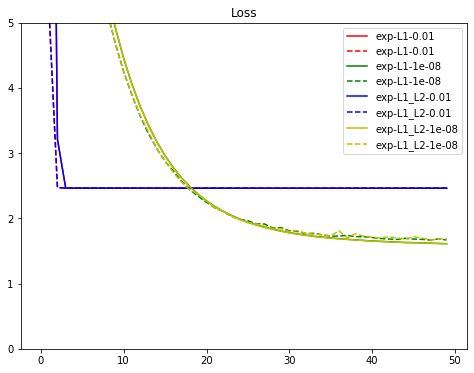

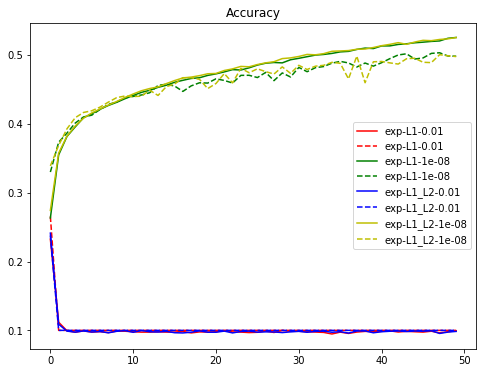

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()